# QAOA implementation on Max-Cut problem

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import  QiskitRuntimeService   
from scipy.optimize import minimize

import warnings

In [3]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

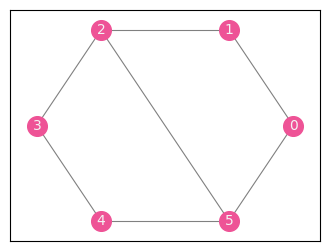

In [22]:
plt.rcParams["figure.figsize"] = (4, 3)

graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3, 4, 5])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (0, 5), (2, 5), (3, 4), (4, 5)])
pos = nx.circular_layout(graph)
nx.draw_networkx(graph,
                pos=pos,
                with_labels=True,
                node_size=200,
                node_color="#EE5396",
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=10,
                font_color="#F4F4F4"
                )

Adjacency is essentially a matrix which tells you which nodes are connected. This matrix is given as a sparse matrix, 
so we need to convert it to a dense matrix

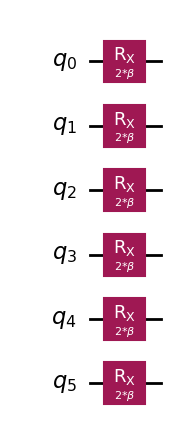

In [23]:
adjacency = nx.adjacency_matrix(graph).todense()

N_QUBITS = 6

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_mix.rx(2 * beta, i)

qc_mix.draw(fold = -1,style='iqx', output='mpl')

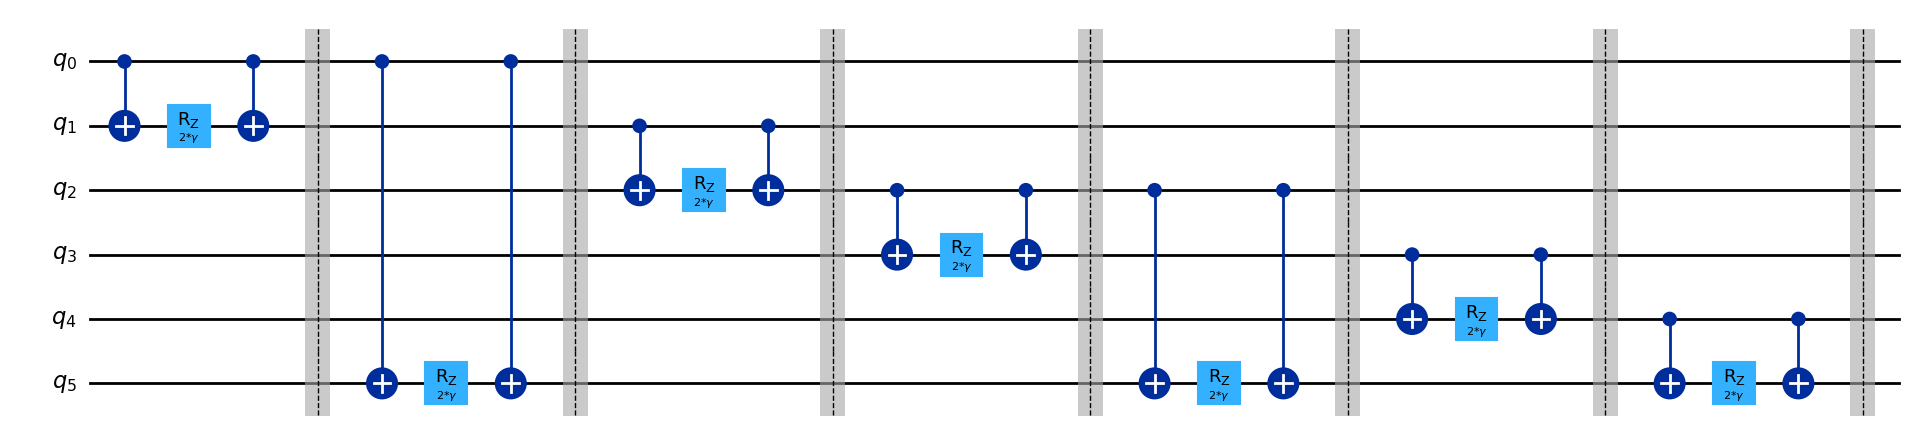

In [24]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw(fold = -1,style='iqx', output='mpl')

### The Initial State

The initial state used during QAOA is usually an equal superposition of all the basis states i.e.

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$

Such a state, when the number of qubits is 4 ($n=4$), can be prepared by applying Hadamard gates starting from an all-zero state as shown in 
the circuit below. 

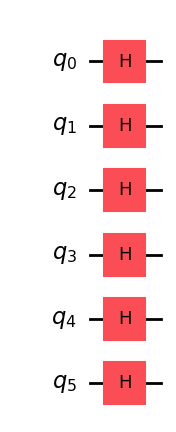

In [25]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw(fold = -1,style='iqx', output='mpl')

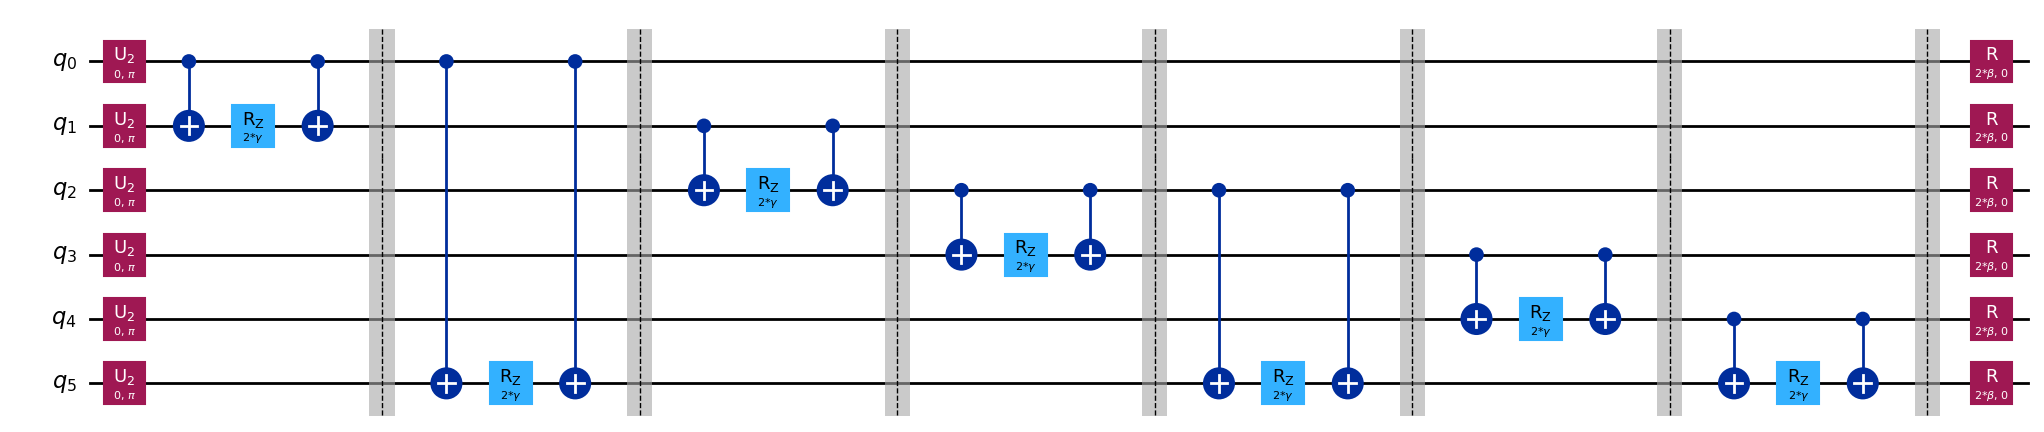

In [26]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw(fold = -1,style='iqx', output='mpl')

In [27]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    # pylint: disable=invalid-name
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [28]:

expectation = get_expectation(graph)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.9189453125
       x: [ 2.754e+00  3.975e-01]
    nfev: 31
   maxcv: 0.0

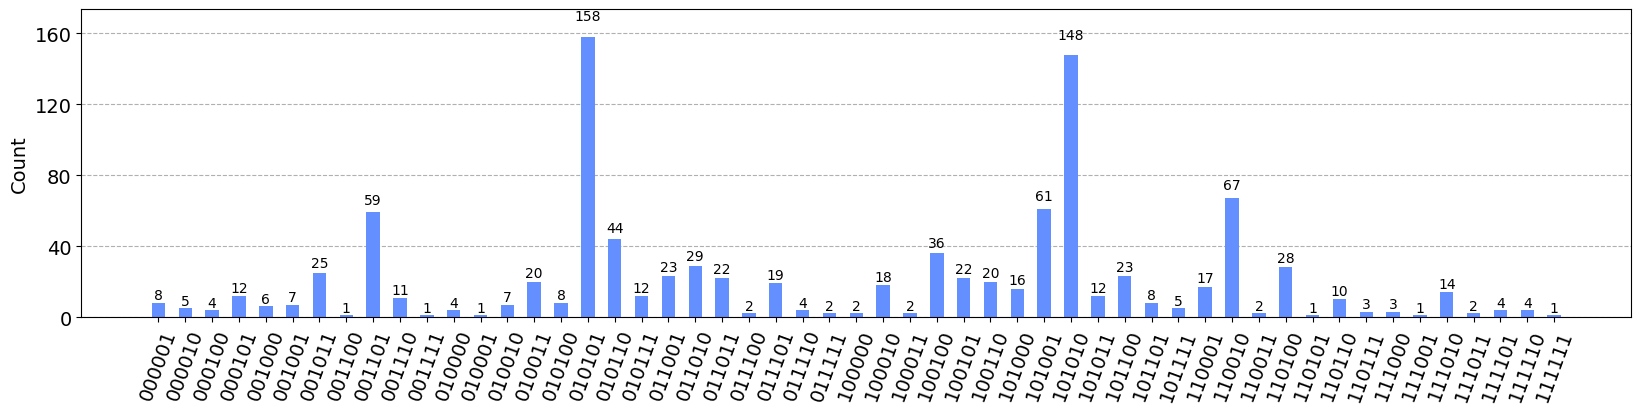

In [38]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512


qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts, figsize=(20, 4))


In [39]:

QiskitRuntimeService.save_account(channel="ibm_quantum", token='2a4b0eb9cd3069ee20cfbc5595a1cff34239ddce2d2b9b1c5fe65752940626f64c7257fab1e72126d93ff496af9a2d288c16529fee07780480a0a2b238f0cc80',overwrite=True)


service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_osaka'

In [50]:
backend.shots = 512

qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)
